# Setup

In [ ]:
import gym
import tensorflow as tf
import retro

import numpy as np
import random as r

from skimage import transform # to preprocess game frames
from skimage.color import rgb2gray # to convert game frames into grayscale
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import tensorflow as tf
from tensorflow.keras import models, layers, datasets

from collections import deque # to create ordered collections of frames

import warnings # ignore warning messages from skiimage during training

warnings.filterwarnings("ignore")

# Create Env

Frame Size:  Box(210, 160, 3)
Action Space:  6  moves

This is what the agent sees: 


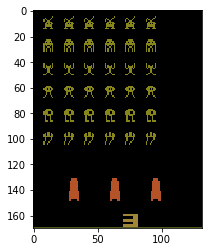

In [3]:
env = gym.make('SpaceInvaders-v0') # make env

print("Frame Size: ", env.observation_space)
print("Action Space: ", env.action_space.n, " moves")

moves = np.array(np.identity(env.action_space.n, dtype=int).tolist())

UP = 26
DOWN = -14
LEFT = 14
RIGHT = -14

H = 210 - (UP - DOWN) # height of preprocessed image
W = 160 - (LEFT - RIGHT) # width of preprocessed image

obs = env.reset()[UP:DOWN, LEFT:RIGHT]

%matplotlib inline
img = Image.fromarray(obs, 'RGB')

print("\nThis is what the agent sees: ")
imshow(np.asarray(img))

In [4]:
for i_episode in range(1):
    observation = env.reset()
    print("input size", observation.shape)
#     for t in range(1):
#         env.render()
#         print(observation)
#         action = env.action_space.sample()
#         observation, reward, done, info = env.step(action)
#         if done:
#             print("Episode finished after {} timesteps".format(t+1))
#             break

input size (210, 160, 3)


# Hyperparameters

In [67]:
# model
STACK_SIZE = 4 # "phi length" - how many frames we consolidate into one training example
STATE_SIZE = [H, W, STACK_SIZE] # stack dimensions
print(STATE_SIZE)
ACTION_SIZE = env.action_space.n # 6 possible moves
LEARNING_RATE = 2.5e-4

# training
NUM_GAMES = 250 # how many games we will play for training
MAX_STEPS = 50000 # max number of moves we'll make each game
HIDDEN_UNITS = 512
BATCH_SIZE = 28 # num of states we include for each weight update in gradient descent
TRAINING = True # when you just want agent to play
ENV_RENDER = True # when you want to see env

# explore params
EXP_START = 1.0
EXP_STOP = 0.01
DECAY = 1e-5

# q le table
GAMMA = 0.001 # discount for future rewards in bellman equation

# memory
LOAD_MEM = 64 # num experiences to be stored in memory during initialization
MEMORY_SIZE = int(1e6) # max num experiences stored in memory

[170, 132, 4]


# Preprocess raw input from game

In [68]:
def state_to_frame(state):
    
#     print("Input Size: ", state.shape)
    
    gray_doe = rgb2gray(state)
    crop_doe = gray_doe[UP:DOWN, LEFT:RIGHT]
    frame = crop_doe / 255.0
    
#     print("Output Size: ", frame.shape)
    
    return  frame # Shape = 172 height, 132 width | vals = [0, 1]

In [69]:
def stack_frames(stack_o_frames, state, is_new_game):
    
    frame = state_to_frame(state)
    
    if is_new_game: # if new game, clear stack from last game
        
        stack_o_frames = deque([np.zeros((H,W), dtype=np.int) for i in range(STACK_SIZE)], maxlen=STACK_SIZE)
        
        for i in range(STACK_SIZE): # in new game, start with copies of OG frame
            stack_o_frames.append(frame)
            
#         print("Stack Size: ", len(stack_o_frames))  
#         print("State Size: ", state.shape)
        
    else: # if we already have stack, append latest frame
        
        stack_o_frames.append(frame) # deque automatically removes oldest frame
        
    state = np.stack(stack_o_frames, axis=2) # input to neural net
        
    return stack_o_frames, state

# Memory module

In [70]:
class Memory():
    def __init__(self):
        self.buffer = deque(maxlen = MEMORY_SIZE)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=BATCH_SIZE,
                                 replace=False)
        
        return [self.buffer[i] for i in index]

# Load memory

In [71]:
memory = Memory()

state = env.reset() # reset game
stack = deque([np.zeros((H,W), dtype=np.int) for i in range(STACK_SIZE)], maxlen=STACK_SIZE) # load deque with zeros

# load first state, create first stack
stack, state = stack_frames(stack, state, is_new_game=True)

for i in range(LOAD_MEM):
    
    choice = r.randint(1, len(moves)) - 1 # random index
    action = moves[choice] # chosen index
    next_state, reward, done, _logs_ = env.step(choice) # act
    
    env.render()
    
    stack, next_state = stack_frames(stack, next_state, is_new_game=False) # save next state
    
    if done: # when we lose, create a 0-matrix for next_state
        next_state = np.zeros(state.shape)
    
    memory.add((state, action, reward, next_state, done)) # add experience to memory 
    
    state = next_state
    
    if done: # start new game
        state = env.reset()
        stack, state = stack_frames(stack, state, is_new_game=True) 

print("Experiences Loaded: ", len(memory.buffer))

env.close()

Experiences Loaded:  64


# Tensorboard

# Model

In [107]:
class dqn:
    def __init__(self, name='dqn'):
        
        self.model = models.Sequential()
        
        self.model.add(layers.Conv2D(filters=32, 
                                kernel_size=(8, 8), 
                                strides=4,
                                activation='relu', 
                                input_shape=(STATE_SIZE)))
        
        self.model.add(layers.Conv2D(filters=64, 
                                kernel_size=(4, 4),
                                strides=2,
                                activation='relu'))
        
        self.model.add(layers.Conv2D(filters=64, 
                                kernel_size=(3, 3),
                                strides=2,
                                activation='relu'))
        
        self.model.add(layers.Flatten())
        
        self.model.add(layers.Dense(64, activation='relu'))
        
        self.model.add(layers.Dense(ACTION_SIZE, activation='softmax'))
        
        print(self.model.summary())
    
    
    def backprop(self, loss_fn, q_predict, q_target, optimizer='adam'):
        return self.model.compile(optimizer=optimizer, loss=loss_fn(q_predict, q_target))
    
    
    def predict(self, x):
        return self.model.predict(x)
    

In [117]:
def loss_fn(q_predict, q_target):
    return tf.reduce_mean(tf.square(q_target - q_predict))

# Training Runs

In [109]:
def move(model, stack, moves, training_step):
    
    adventure = r.uniform(0, 1)

    explore_prob = EXP_STOP - (EXP_START - EXP_STOP) * np.exp(-DECAY * training_step)

    if explore_prob > adventure: # explore randomly
        choice = r.randint(1, len(moves)) - 1
        action = moves[choice]
        
    else: # use dqn
        dq_table = model.predict(tf.expand_dims(state, 0))
        choice = np.argmax(dq_table) # pick move with highest predicted q val
        action = moves[choice]
        
    return action, explore_prob

In [114]:
def train(model, memory):

    batch = memory.sample()

    # retrieve minibatches from memory
    states_mini = np.array([states[0] for states in batch], ndmin=3)
    actions_mini = np.array([actions[1] for actions in batch])
    rewards_mini = np.array([rewards[2] for rewards in batch])
    next_states_mini = np.array([next_states[3] for next_states in batch], ndmin=3)
    dones_mini = np.array([dones[4] for dones in batch])
    
    q_target = []
    
    # predict q vals for next state
    q_predict = model.predict(next_states_mini)
    
    for i in range(0, len(batch)): # loop through batches
        
        gameover = dones_mini[i]
        
        if gameover: # target_q = reward
            q_target.append(rewards_mini[i])
        
        else: # target_q = reward + gamma * max_q(s', a')
            target = rewards_mini[i] + GAMMA * np.max(q_predict[i])
            q_target.append(target)
            
    targets_mini = np.array([target for target in q_target]) # create minibatch of target q vals
    
    # calculate loss and backprop on minibatches
    @tf.function
    def train_one_batch()
        with tf.GradientTape() as tape:
            loss = loss_fn(q_predict, q_target)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    
    model.backprop(q_predict, q_target)
    
    pass 

In [115]:
if TRAINING == True:
    
    model = dqn()
    training_step = 0
    
    for game in range (NUM_GAMES + 1):
        
        game_step = 0
        game_rewards = []
        state = env.reset()
        
        stack, state = stack_frames(stack, state, is_new_game=True)
        
        while game_step < MAX_STEPS:
            
            game_step += 1
            training_step += 1
            
            action, explore_prob = move(model, state, moves, training_step) # choose move
                
            next_state, reward, done, _logs_ = env.step(np.argmax(action)) # act
            
            if ENV_RENDER: # show games
                env.render()
                
            game_rewards.append(reward)
            
            if done: # we've lost
                next_state = np.zeros(state.shape)
                stack, next_state = stack_frames(stack, next_state, is_new_game=False) 
                game_step = MAX_STEPS
                total_reward = np.sum(game_rewards)
                memory.add((state, action, reward, next_state, done))

                print('Game: {}'.format(game), 
                      'Score: {}'.format(round(total_reward, 3)),
                      'Explore Prob: {}'.format(round(explore_prob, 3)),
                      'Training Loss {}'.format(round(loss, 4)))
        
            else: # we're still alive!
                stack, next_state = stack_frames(stack, next_state, is_new_game=False)
                memory.add((state, action, reward, next_state, done))
                state = next_state
                
            train(model, memory)
                
            if game % 5 == 0: # save model every five games
                print('Checkpoint')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 41, 32, 32)        8224      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 19, 15, 64)        32832     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 9, 7, 64)          36928     
_________________________________________________________________
flatten_19 (Flatten)         (None, 4032)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 390       
Total params: 336,486
Trainable params: 336,486
Non-trainable params: 0
_______________________________________________

InvalidArgumentError: input must be 4-dimensional[28,6] [Op:Conv2D]

In [116]:
saver = tf.train.Saver() 

if TRAINING == True:
    
    with tf.Session() as sesh:
        
        tf.global_variables_initializer().run()
        
        training_step = 0
        
        for game in range(NUM_GAMES+1): # play games
            
            # initialize
            game_step = 0
            game_rewards = []
            state = env.reset()
            
            stack, state = stack_frames(stack, state, is_new_game=True)
            
            while game_step < MAX_STEPS:
                
                game_step += 1
                training_step += 1
                
                action, explore_prob = move(state, moves, training_step) # choose move
                
                next_state, reward, done, _logs_ = env.step(np.argmax(action)) # act
                
                if ENV_RENDER: # show games
                    env.render()
                    
                game_rewards.append(reward) # track reward
                
                if done: # we've lost
                    next_state = np.zeros(state.shape)
                    stack, next_state = stack_frames(stack, next_state, is_new_game=False) 
                    game_step = MAX_STEPS
                    total_reward = np.sum(game_rewards)
                    memory.add((state, action, reward, next_state, done))
                    
                    print('Game: {}'.format(game), 
                          'Score: {}'.format(round(total_reward, 3)),
                          'Explore Prob: {}'.format(round(explore_prob, 3)),
                          'Training Loss {}'.format(round(loss, 4)))
        
                else: # we're still alive!
                    stack, next_state = stack_frames(stack, next_state, is_new_game=False)
                    memory.add((state, action, reward, next_state, done))
                    state = next_state
                
                loss = learn(DQN, memory, sesh)
                
            if game % 5 == 0: # save model every five games
                save_path = saver.save(sesh, './models/model.cpkt')
                print('Checkpoint')

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Saver'

In [87]:
# %%bash
# tensorboard --logdir='./tensorboard/dqn'

# Test

In [ ]:
with tf.Session() as sesh:
    total_test_rewards = []
    
    saver.restore(sesh, "./models/model.cpkt")
    
    for game in range(3):
        total_rewards = 0
        state = env.reset()
        stack, state = stack_frames(stack, state, is_new_game=True)
        
        print("****************************************************")
        print("GAME ", game)
        
        done = False
        
        while not done:
            state = state.reshape((1, *STATE_SIZE))
            q_vals = sesh.run(DQN.output, feed_dict={DQN.inputs_:state})
            
            next_state, reward, done, _logs_ = env.step(np.argmax(q_vals))
            
            env.render()
            
            total_rewards += reward
            
            if done:
                print("Score: ", total_rewards)
                total_test_rewards.append(total_rewards)
            
            stack, next_state = stack_frames(stack, next_state, is_new_game=False)
            state = next_state
            
    env.close()

In [ ]:
%%bash
ls

In [ ]:
writer = tf.summary.FileWriter("./tensorboard/dqn/1") # write

tf.summary.scalar("Loss", DQN.loss) 

write_op = tf.summary.merge_all() # merge

In [ ]:
class DQN:
    def __init__(self, name="DQN"):
        
        with tf.variable_scope(name): # create model skeleton, using placeholders for data to be fed in
            
            self.inputs_ = tf.placeholder(dtype=tf.float32, 
                                          shape=[None, *STATE_SIZE], 
                                          # *STATE_SIZE means we take each element of STATE_SIZE and input sequentially
                                          # ie. [None, 110, 84, 4] instead of [None, [110, 84, 4]]
                                          name="inputs")
            
            self.inputs_shape = self.inputs_.get_shape()
            
            self.actions_ = tf.placeholder(dtype=tf.float32,
                                           shape=[None, ACTION_SIZE],
                                           name="actions")
            
            # Target QVal = Reward (state | actions) + discount * QVal (new_state | total_possible_actions)
            self.target_q = tf.placeholder(dtype=tf.float32,
                                           shape=[None],
                                           name="target_q")
            
            # First Convolution
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_,
                                          filters=32,
                                          kernel_size=[8,8],
                                          strides=[4,4],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv1")
            
            # Output size = (W−K+2P)/S+1
            # height = (108 - 8 + 2*0) / 4 + 1= 26
            # width = (84 - 8) / 4 + 1= 20
            
            self.conv1_shape = self.conv1.get_shape()
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out") # shape = (batch_size, 26 ht, 20 wd, 32 filters)
            
            # Second Convolution
            self.conv2 = tf.layers.conv2d(inputs=self.conv1_out,
                                          filters=64,
                                          kernel_size=[4,4],
                                          strides=[2,2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv2")
            
            self.conv2_shape = self.conv2.get_shape()
            
            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out") # shape = (batch_size, 12 ht, 9 wd, 64 filters)
            
            # Third Convolution
            self.conv3 = tf.layers.conv2d(inputs=self.conv2_out,
                                          filters=64,
                                          kernel_size=[3,3],
                                          strides=[2,2],
                                          padding="VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv3")
            
            self.conv3_shape = self.conv2.get_shape()
            
            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out") # shape = (batch size, 12 ht, 9 wd, 64 filters)
            
            # Flat
            self.flat = tf.layers.flatten(self.conv3_out)
            
            self.flat_shape = self.flat.get_shape()
            
            # Hidden Layer
            self.fully_connected = tf.layers.dense(inputs=self.flat,
                                                   units=HIDDEN_UNITS,
                                                   activation=tf.nn.relu,
                                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                   name="fc1")
            
            self.fully_connected_shape = self.fully_connected.get_shape()
            
            # Linear
            self.output = tf.layers.dense(inputs=self.fully_connected,
                                          units=ACTION_SIZE)
            
            self.output_shape = self.output.get_shape()
            
            # q val
            self.q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
        
            # loss = (discounted_q_vals_in_future - q_val_of_move)^2
            self.loss = tf.reduce_mean(tf.square(self.target_q - self.q))
            
            # backprop
            self.optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.loss)                    
            
    def print_shapes(self):
        print("inputs ", self.inputs_shape)
        print("c1 ", self.conv1_shape)
        print("c2 ", self.conv2_shape)
        print("c3 ", self.conv3_shape)
        print("flat ", self.fully_connected_shape)
        print("fully_connected ", self.fully_connected_shape)
        print("output ", self.output_shape)
            